# Citi Bike Data Analysis
====================================

### Setup

In [11]:
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import pandas as pd

/Users/danielstallworth/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [14]:
%matplotlib inline

In [3]:
r = requests.get('http://www.citibikenyc.com/stations/json')

In [4]:
r.json().keys()

[u'executionTime', u'stationBeanList']

In [5]:
len(r.json()['stationBeanList'])

508

### The real data is in stationBeanList

In [7]:
key_list = []
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in key_list:
            key_list.append(k)

In [8]:
key_list

[u'availableDocks',
 u'totalDocks',
 u'city',
 u'altitude',
 u'stAddress2',
 u'longitude',
 u'lastCommunicationTime',
 u'postalCode',
 u'statusValue',
 u'testStation',
 u'stAddress1',
 u'stationName',
 u'landMark',
 u'latitude',
 u'statusKey',
 u'availableBikes',
 u'id',
 u'location']

In [10]:
df = json_normalize(r.json()['stationBeanList'])

### Can see the difference between number of available bikes per station and total docks per station

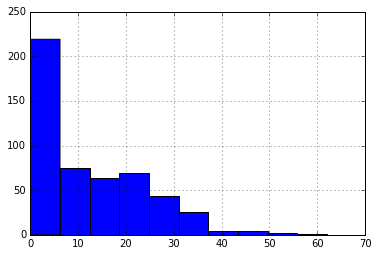

In [15]:
df['availableBikes'].hist()
plt.show()

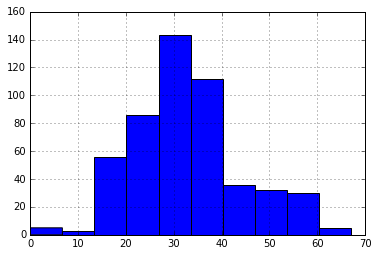

In [27]:
df['totalDocks'].hist()
plt.show()

In [17]:
df['availableBikes'].mean()

12.338582677165354

In [18]:
df['availableBikes'].median()

9.0

### No test stations, but 8 are currently not in service

In [19]:
df.groupby('statusKey')['availableBikes'].mean()

statusKey
1    12.536
3     0.000
Name: availableBikes, dtype: float64

In [21]:
df.groupby('testStation')['availableBikes'].count()

testStation
False    508
Name: availableBikes, dtype: int64

In [23]:
df.groupby('statusValue')['availableBikes'].count()

statusValue
In Service        500
Not In Service      8
Name: availableBikes, dtype: int64

### Putting the data in a sqlite db

In [28]:
import sqlite3 as lite

In [71]:
con = lite.connect('citi_bike.db')
cur = con.cursor()

In [32]:
cur.execute('DROP TABLE citibike_reference')

In [33]:
with con:
    cur.execute('''CREATE TABLE citibike_reference (
                id INT PRIMARY KEY, 
                totalDocks INT,
                city TEXT,
                altitude INT, 
                stAddress2 TEXT, 
                longitude NUMERIC, 
                postalCode TEXT,
                testStation TEXT,
                stAddress1 TEXT,
                stationName TEXT, 
                landMark TEXT,
                latitude NUMERIC,
                location TEXT)''')

In [34]:
sql = '''INSERT INTO citibike_reference (id, totalDocks, city, altitude, stAddress2, longitude, postalCode,
                                        testStation, stAddress1, stationName, landMark, latitude, location)
                                        VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)'''

In [35]:
with con:
    for s in r.json()['stationBeanList']:
        cur.execute(sql, (s['id'], s['totalDocks'], s['city'], s['altitude'], s['stAddress2'], s['longitude'], s['postalCode'],
                    s['testStation'], s['stAddress1'], s['stationName'], s['landMark'], s['latitude'], s['location']))

In [55]:
cur.execute('DROP TABLE available_bikes')

### Get the number of available bikes at various times over an hour and put then in the db

In [48]:
station_ids = ['_' + str(x) + ' INT' for x in df['id'].tolist()]

In [57]:
with con:
    cur.execute('CREATE TABLE available_bikes (execution_time INT, ' + ','.join(station_ids) + ');')

In [59]:
print('CREATE TABLE available_bikes (execution_time INT, ' + ','.join(station_ids) + ');')

CREATE TABLE available_bikes (execution_time INT, _72 INT,_79 INT,_82 INT,_83 INT,_116 INT,_119 INT,_120 INT,_127 INT,_128 INT,_137 INT,_143 INT,_144 INT,_146 INT,_147 INT,_150 INT,_151 INT,_152 INT,_153 INT,_157 INT,_161 INT,_164 INT,_167 INT,_168 INT,_173 INT,_174 INT,_195 INT,_212 INT,_216 INT,_217 INT,_223 INT,_224 INT,_225 INT,_228 INT,_229 INT,_232 INT,_236 INT,_237 INT,_238 INT,_239 INT,_241 INT,_242 INT,_243 INT,_244 INT,_245 INT,_247 INT,_248 INT,_249 INT,_250 INT,_251 INT,_252 INT,_253 INT,_254 INT,_257 INT,_258 INT,_259 INT,_260 INT,_261 INT,_262 INT,_263 INT,_264 INT,_265 INT,_266 INT,_267 INT,_268 INT,_270 INT,_274 INT,_275 INT,_276 INT,_278 INT,_279 INT,_280 INT,_281 INT,_282 INT,_284 INT,_285 INT,_289 INT,_291 INT,_293 INT,_295 INT,_296 INT,_297 INT,_298 INT,_300 INT,_301 INT,_302 INT,_303 INT,_304 INT,_305 INT,_306 INT,_307 INT,_308 INT,_309 INT,_310 INT,_311 INT,_312 INT,_313 INT,_315 INT,_316 INT,_317 INT,_319 INT,_320 INT,_321 INT,_322 INT,_323 INT,_324 INT,_325 INT,

In [77]:
import time
from datetime import datetime

In [40]:
from dateutil.parser import parse
import collections

In [50]:
exec_time = parse(r.json()['executionTime'])

In [63]:
r.json()['executionTime']

u'2016-06-25 04:41:11 AM'

In [51]:
with con:
    cur.execute('INSERT INTO available_bikes (execution_time) VALUES (?)',(exec_time.strftime('%s'),))

In [62]:
exec_time

'1466847671'

In [52]:
id_bikes = collections.defaultdict(int)

In [53]:
for station in r.json()['stationBeanList']:
    id_bikes[station['id']] = station['availableBikes']

In [54]:
with con:
    for k,v in id_bikes.iteritems():
        cur.execute('UPDATE available_bikes SET _' + str(k) + ' = ' + str(v) + ' WHERE execution_time = ' + 
                    exec_time.strftime('%s') + ';')

In [58]:
for i in range(60): # Inserts data into the DB every minute for an hour
    r = requests.get('http://www.citibikenyc.com/stations/json')
    exec_time = parse(r.json()['executionTime']).strftime("%s")

    cur.execute('INSERT INTO available_bikes (execution_time) VALUES (?)', (exec_time,))

    for station in r.json()['stationBeanList']:
        cur.execute("UPDATE available_bikes SET _%d = %d WHERE execution_time = %s" % (station['id'], 
                                                                station['availableBikes'], exec_time))
    con.commit()

    time.sleep(60)

con.close() #close the database connection when done

### Can find the stations with the greatest activity over the hour

In [72]:
df1 = pd.read_sql_query('SELECT * FROM available_bikes ORDER BY execution_time',con,index_col = 'execution_time')

In [93]:
df1.head()

,_72,_79,_82,_83,_116,_119,_120,_127,_128,_137,...,_3242,_3243,_3244,_3246,_3249,_3254,_3255,_3256,_3259,_3260
execution_time,,,,,,,,,,,,,,,,,,,,,
1466841857,15,2,16,42,9,9,14,25,20,16,...,38,4,6,33,4,28,24,0,7,4
1466841920,15,2,16,42,9,9,14,25,20,16,...,38,4,6,33,4,28,24,0,7,3
1466841972,15,2,16,42,9,9,14,25,20,16,...,38,4,6,33,4,28,24,0,7,3
1466842046,15,2,16,42,9,9,14,26,19,15,...,38,4,6,33,4,28,24,0,7,3
1466842088,15,2,16,42,9,9,14,26,19,15,...,38,4,6,33,4,28,24,0,7,3


In [74]:
hour_change = collections.defaultdict(int)
for col in df1.columns: # for each station
    station_vals = df1[col].tolist()
    station_id = col[1:] # trimming _
    station_change = 0
    for k,v in enumerate(station_vals):
        if k < len(station_vals) - 1: # Up to the 2nd to last row in each column
            station_change += abs(station_vals[k] - station_vals[k+1]) # abs value of the change every minute
    hour_change[int(station_id)] = station_change

In [75]:
def keyWithMaxVal(d):
    '''Find key with greatest value change'''
    return max(d, key = lambda k: d[k])

In [106]:
def top10MaxVals(d):
    '''Find key with greatest value change'''
    return sorted(d, key = d.get, reverse = True)[:10]

In [107]:
top_ten = top10MaxVals(hour_change)

In [149]:
top_ten

[281, 284, 351, 368, 385, 433, 445, 499, 2003, 3190]

In [76]:
max_station = keyWithMaxVal(hour_change)

### Station with the most activity has one of the highest station numbers with 27 bike exchanges even at 3am

In [78]:
cur.execute('SELECT id, stationname, latitude, longitude FROM citibike_reference WHERE id = ?', (max_station,))
data = cur.fetchone()
print('The most active station is station id %s at %s, latitude: %s, longitude: %s' % data)
print('With %d bikes coming and going in the hour between %s and %s' % (hour_change[max_station], 
         datetime.fromtimestamp(int(df1.index[0])).strftime('%Y-%m-%dT%H:%M:%S'),
         datetime.fromtimestamp(int(df1.index[-1])).strftime('%Y-%m-%dT%H:%M:%S'),))

The most active station is station id 3190 at Garfield Ave Light Rail, latitude: 40.7108044, longitude: -74.0714882
With 27 bikes coming and going in the hour between 2016-06-25T03:04:17 and 2016-06-25T04:41:11


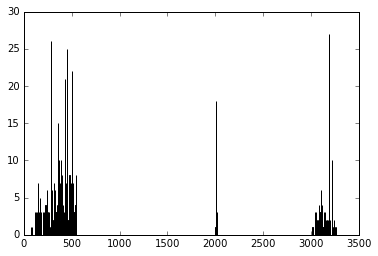

In [79]:
plt.bar(hour_change.keys(), hour_change.values())
plt.show()

In [186]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import random
from matplotlib import cm

In [113]:
','.join(str(v) for v in top_ten)

'3190,281,445,499,433,2003,284,351,368,385'

In [114]:
ref = pd.read_sql_query('SELECT id, stationname, latitude, longitude FROM citibike_reference WHERE id in (' 
                        + ','.join(str(v) for v in top_ten) + ')',
                        con,index_col = 'id')

### Top 10 stations with highest activity (not in order of activity)

In [117]:
ref

,stationName,latitude,longitude
id,,,
281,Grand Army Plaza & Central Park S,40.764397,-73.973715
284,Greenwich Ave & 8 Ave,40.739017,-74.002638
351,Front St & Maiden Ln,40.705310,-74.006126
368,Carmine St & 6 Ave,40.730386,-74.002150
385,E 55 St & 2 Ave,40.757973,-73.966033
433,E 13 St & Avenue A,40.729554,-73.980572
445,E 10 St & Avenue A,40.727408,-73.981420
499,Broadway & W 60 St,40.769155,-73.981918
2003,1 Ave & E 18 St,40.733812,-73.980544


### Can then plot the top 10 stations. Probably should look at more stations to see if anything stands out.

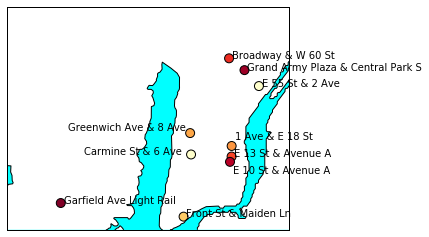

In [212]:
fig = plt.figure()
m = Basemap(projection = 'merc',llcrnrlat = 40.7, urcrnrlat = 40.79,
            llcrnrlon = -74.1, urcrnrlon = -73.95, lat_ts = 40.5, area_thresh = 0.1, resolution='f')
m.drawcoastlines()
m.drawrivers()
m.fillcontinents(color = 'white',lake_color = 'aqua', zorder = 0)
m.drawmapboundary(fill_color = 'aqua') 

labels = ref['stationName']
x_offsets = [130,-5500,130,-4800,130,130,130,130,130,130]
y_offsets = [0,100,0,0,0,0,-500,0,300,0]

x,y = m([float(x) for x in ref['longitude']], [float(x) for x in ref['latitude']])

for label, xpt, ypt, x_offset, y_offset in zip(labels, x, y, x_offsets, y_offsets):
    plt.text(xpt+x_offset, ypt+y_offset, label)

cor = [hour_change[v] for v in sorted(top_ten)]
cmap = plt.get_cmap('YlOrRd')
cax = cm.ScalarMappable(cmap=cmap)
cax.set_array(cor)
#cax.make_axes(orientation = 'horizontal')
ax = plt.gca()

m.scatter(x=x, y=y, s = 80, c = cor, marker = 'o', cmap = cmap, ax = ax)
#m.colorbar(cax)
plt.show()